In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [98]:
from typing import Literal, Optional
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage
from langchain_core.messages import SystemMessage

from utils import show_graph
from prompts import BASE_PROMPT, PATIENT_INFO_PROMPT

class AgentState(MessagesState):
    """State for the chatbot"""
    patient_name: str
    patient_age: int
    patient_sex: Literal["male", "female"]

    # symptoms: list[str]
    # red_flags: list[str]
    # associated_conditions: list[str]
    # medical_history: list[str]
    # urgency: Literal["low", "medium", "high"]


In [99]:
# Phase 1: Patient Information Collection
class PatientInfoPartial(BaseModel):
    name: Optional[str] = Field(description="The name of the patient")
    age: Optional[int] = Field(description="The age of the patient")
    sex: Optional[Literal["male", "female"]] = Field(description="The biological sex of the patient")
    
llm = init_chat_model(model="gpt-4o-mini", temperature=0)
extract_llm = llm.with_structured_output(PatientInfoPartial)

def ask_patient_info(state: AgentState) -> AgentState: 
    missing = []
    if state.get("patient_name") is None: missing.append("name")
    if state.get("patient_age") is None: missing.append("age")
    if state.get("patient_sex") is None: missing.append("sex")

    known_bits = []
    if state.get("patient_name") is not None: known_bits.append(f"name={state['patient_name']}")
    if state.get("patient_age") is not None: known_bits.append(f"age={state['patient_age']}")
    if state.get("patient_sex") is not None: known_bits.append(f"sex={state['patient_sex']}")

    steering = (
        "You are collecting basic patient demographic information for triage.\n"
        f"Known so far: {', '.join(known_bits) if known_bits else 'none'}.\n"
        f"Missing (in order): {', '.join(missing) if missing else 'none'}.\n"
        "- If anything is missing, ask ONLY for the first missing field with one concise question.\n"
        "- Keep it friendly and brief.\n"
        "- If nothing is missing, acknowledge completion of this stage."
    )

    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=PATIENT_INFO_PROMPT),
        SystemMessage(content=steering),
        *state["messages"],
    ]
    resp = llm.invoke(msgs)

    return {"messages": [resp]}

def extract_patient_info(state: AgentState) -> AgentState:
    human_only = [m for m in state.get("messages", []) if isinstance(m, HumanMessage)]
    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=(
            PATIENT_INFO_PROMPT +
            "\nOnly extract info stated by the patient. If not present, leave that field null."
        )),
        *human_only,
    ]
    parsed: PatientInfoPartial = extract_llm.invoke(msgs)

    updates = {}
    if parsed.name is not None and state.get("patient_name") is None:
        updates["patient_name"] = parsed.name
    if parsed.age is not None and state.get("patient_age") is None:
        updates["patient_age"] = parsed.age
    if parsed.sex is not None and state.get("patient_sex") is None:
        updates["patient_sex"] = parsed.sex
    return updates


builder = StateGraph(AgentState)
builder.add_node("collect_patient_info", extract_patient_info)
builder.add_node("ask_patient_info", ask_patient_info)

builder.add_edge(START, "ask_patient_info")
builder.add_edge("ask_patient_info", "collect_patient_info")
builder.add_edge("collect_patient_info", END)

graph = builder.compile()


In [100]:
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

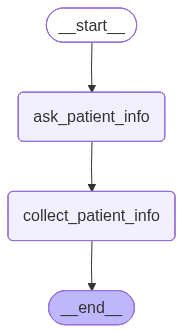

In [101]:
show_graph(graph)

In [102]:
from langchain_core.messages import HumanMessage

state = {
    "messages": [],
    "patient_name": None,
    "patient_age": None,
    "patient_sex": None,
}

config = {"configurable": {"thread_id": "1"}}

# Initial invoke
for event in graph.stream({"messages": []}, config, stream_mode="values"):
    if "messages" in event and event["messages"]:
        print("Assistant:", event["messages"][-1].content)

# Loop
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    
    # Continue from interrupt with user's message
    for event in graph.stream({"messages": [HumanMessage(content=user_input)]}, config, stream_mode="values"):
        if "messages" in event and event["messages"]:
            print("Assistant:", event["messages"][-1].content)
    
    # Check state
    snapshot = graph.get_state(config)
    if is_complete(snapshot.values):
        s = snapshot.values
        print(f"\n✓ Complete! Name: {s['patient_name']}, Age: {s['patient_age']}, Sex: {s['patient_sex']}")
        break

Assistant: Hi there! Let's start with your name. What is your name?
Assistant: Wang Junwei
Assistant: Thank you, Wang Junwei! How old are you?
Assistant: Thank you, Wang Junwei! How old are you?
Assistant: 23 yo
Assistant: Great! And what is your sex?
Assistant: Great! And what is your sex?
Assistant: male
Assistant: Thank you for providing that information, Wang Junwei. We have completed the patient information collection phase!
Assistant: Thank you for providing that information, Wang Junwei. We have completed the patient information collection phase!

✓ Complete! Name: Wang Junwei, Age: 23, Sex: male


In [69]:

test_msgs = [
    SystemMessage(content=BASE_PROMPT),
    SystemMessage(content=PATIENT_INFO_PROMPT),
    HumanMessage(content="Hi, I'm Jane Doe,"),
]
print(extract_llm.invoke(test_msgs))
# Expect: PatientInfoPartial(name='Jane Doe', age=28, sex='female')

patient_name='Jane Doe' patient_age=None patient_sex=None
